In [5]:
import torch

from torch.utils.data.dataset import random_split

torch.manual_seed(1)

### **Load the dataset**
- MNIST website: http://yann.lecun.com/exdb/mnist/

In [1]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [4]:
train_dataset = datasets.MNIST(
  root = './mnist',
  train = True,
  transform = transforms.ToTensor(),
  download = True
)

test_dataset = datasets.MNIST(
  root = './mnist',
  train = False,
  transform = transforms.ToTensor()
)

NameError: name 'datasets' is not defined

In [3]:
len(train_dataset), len(test_dataset)

(60000, 10000)

In [6]:
train_dataset, val_dataset = random_split(train_dataset, lengths = [55000, 5000])

In [7]:
train_loader = DataLoader(
  dataset = train_dataset,
  batch_size = 64,
  shuffle = True
)

val_loader = DataLoader(
  dataset = val_dataset,
  batch_size = 64,
  shuffle = False
)

test_loader = DataLoader(
  dataset = test_dataset,
  batch_size = 64,
  shuffle = True
)

**Count the Counts of each digit**

In [8]:
from collections import Counter

In [9]:
train_counter = Counter()
for images, labels in train_loader:
  train_counter.update(labels.tolist())

print('\tTraining label distribution:')
print(sorted(train_counter.items()))

	Training label distribution:
[(0, 5419), (1, 6185), (2, 5477), (3, 5681), (4, 5349), (5, 4974), (6, 5422), (7, 5710), (8, 5351), (9, 5432)]


In [10]:
val_counter = Counter()
for images, labels in val_loader:
  val_counter.update(labels.tolist())

print('\tTraining label distribution:')
print(sorted(val_counter.items()))

	Training label distribution:
[(0, 504), (1, 557), (2, 481), (3, 450), (4, 493), (5, 447), (6, 496), (7, 555), (8, 500), (9, 517)]


In [11]:
test_counter = Counter()
for images, labels in test_loader:
  test_counter.update(labels.tolist())

print('\tTraining label distribution:')
print(sorted(test_counter.items()))

	Training label distribution:
[(0, 980), (1, 1135), (2, 1032), (3, 1010), (4, 982), (5, 892), (6, 958), (7, 1028), (8, 974), (9, 1009)]


### **Zero rule classifier / Majority class classifier**
- Check the accuracy for predicting the majority class
- Our model should not perform worse than the majority class accuracy

In [12]:
majority_class = test_counter.most_common(1)[0]
print(f'Majority class: {majority_class[0]}')

baseline_accuracy = majority_class[1] / sum(test_counter.values())
print(f'Accuracy when always predicting the majority class: {baseline_accuracy:.2f} ({baseline_accuracy * 100:.2f}%)')

Majority class: 1
Accuracy when always predicting the majority class: 0.11 (11.35%)


### **Visualize the dataset**

In [13]:
%matplotlib inline

import numpy as np
import torchvision
import matplotlib.pyplot as plt

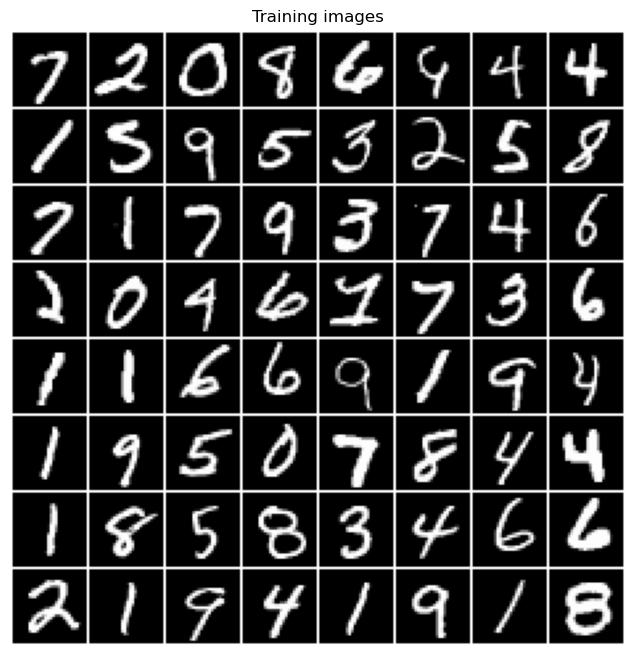

In [14]:
for images, labels in train_loader:
  break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
  images[:64],
  padding=1,
  pad_value=1.0,
  normalize=True),
  (1, 2, 0)))
plt.show()

### **Implement the model**

In [15]:
images.shape  # (batch_size, channel, height, width)

torch.Size([64, 1, 28, 28])

**Need to flatten this image in a vector**

In [16]:
torch.flatten(images, start_dim = 1).shape # (batch_size, features)

torch.Size([64, 784])

In [17]:
class MLP(torch.nn.Module):
  def __init__(self, num_features, num_classes):
    super().__init__()

    self.layers = torch.nn.Sequential(
      # 1st hidden layer
      torch.nn.Linear(num_features, 50),
      torch.nn.ReLU(),

      # 2nd hidden layer
      torch.nn.Linear(50, 25),
      torch.nn.ReLU(),

      # Output layer
      torch.nn.Linear(25, num_classes)
    )
  
  def forward(self, x):
    x = torch.flatten(x, start_dim = 1)
    logits = self.layers(x)
    
    return logits

### **Training loop**

In [19]:
import torch.nn.functional as F

In [18]:
def accuracy(model, dataloader):
  model = model.eval()
  correct = 0.0
  total = 0

  for idx, (features, labels) in enumerate(dataloader):
    with torch.inference_mode():
      logits = model(features)
    
    predictions = torch.argmax(logits, dim = 1)
    compare = labels == predictions
    correct += torch.sum(compare)
    total += len(compare)
  
  return correct / total

In [20]:
epochs = 10
model = MLP(num_features = 784, num_classes = 10)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05)

In [21]:
loss_list = []
val_acc_list = []
train_acc_list = []

In [22]:
for epoch in range(epochs):
  model = model.train()
  
  for batch_idx, (features, labels) in enumerate(train_loader):
    logits = model(features)
    loss = F.cross_entropy(logits, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if not batch_idx % 250:
      print(
        f"Epoch: {epoch + 1:03d}/{epochs:03d}"
        f" | Batch {batch_idx:03d}/{len(train_loader):03d}"
        f" | Train Loss: {loss:.2f}"
      )
    loss_list.append(loss.item())
  
  train_acc = accuracy(model, train_loader)
  val_acc = accuracy(model, val_loader)
  
  print(f'Train accuracy: {train_acc * 100:.2f}% | Val accuracy: {val_acc * 100:.2f}%')

  train_acc_list.append(train_acc)
  val_acc_list.append(val_acc)

Epoch: 001/010 | Batch 000/860 | Train Loss: 2.34
Epoch: 001/010 | Batch 250/860 | Train Loss: 0.88
Epoch: 001/010 | Batch 500/860 | Train Loss: 0.44
Epoch: 001/010 | Batch 750/860 | Train Loss: 0.41
Train accuracy: 87.89% | Val accuracy: 86.98%
Epoch: 002/010 | Batch 000/860 | Train Loss: 0.62
Epoch: 002/010 | Batch 250/860 | Train Loss: 0.21
Epoch: 002/010 | Batch 500/860 | Train Loss: 0.32
Epoch: 002/010 | Batch 750/860 | Train Loss: 0.16
Train accuracy: 89.34% | Val accuracy: 89.06%
Epoch: 003/010 | Batch 000/860 | Train Loss: 0.21
Epoch: 003/010 | Batch 250/860 | Train Loss: 0.42
Epoch: 003/010 | Batch 500/860 | Train Loss: 0.18
Epoch: 003/010 | Batch 750/860 | Train Loss: 0.46
Train accuracy: 93.96% | Val accuracy: 93.32%
Epoch: 004/010 | Batch 000/860 | Train Loss: 0.32
Epoch: 004/010 | Batch 250/860 | Train Loss: 0.42
Epoch: 004/010 | Batch 500/860 | Train Loss: 0.08
Epoch: 004/010 | Batch 750/860 | Train Loss: 0.13
Train accuracy: 94.95% | Val accuracy: 93.70%
Epoch: 005/010 |

### **Evaluating the result**

In [23]:
train_acc = accuracy(model, train_loader)
val_acc = accuracy(model, val_loader)
test_acc = accuracy(model, test_loader)

print(f'Train accuracy: {train_acc * 100:.2f}%')
print(f'Val accuracy: {val_acc * 100:.2f}%')
print(f'Test accuracy: {test_acc * 100:.2f}%')

Train accuracy: 96.89%
Val accuracy: 95.34%
Test accuracy: 95.87%


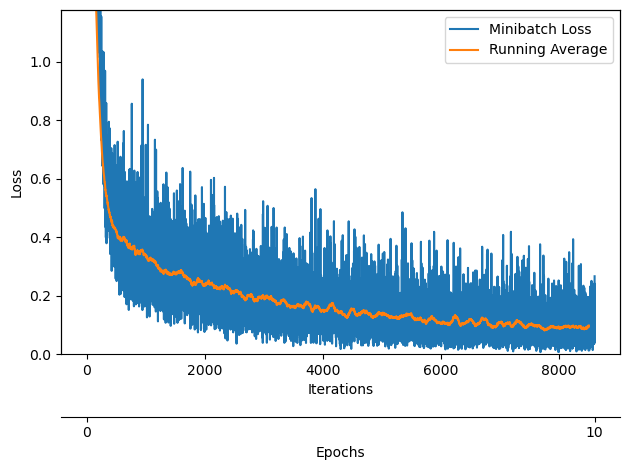

In [24]:
from helpers.plotting import plot_training_loss

plot_training_loss(
  minibatch_loss_list = loss_list,
  num_epochs = epochs,
  iter_per_epoch = len(loss_list) // epochs
)

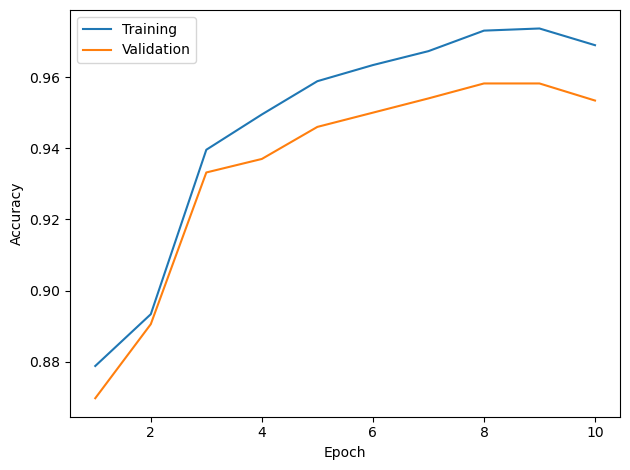

In [25]:
from helpers.plotting import plot_accuracy

plot_accuracy(
  train_acc_list = train_acc_list,
  valid_acc_list = val_acc_list
)